In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error


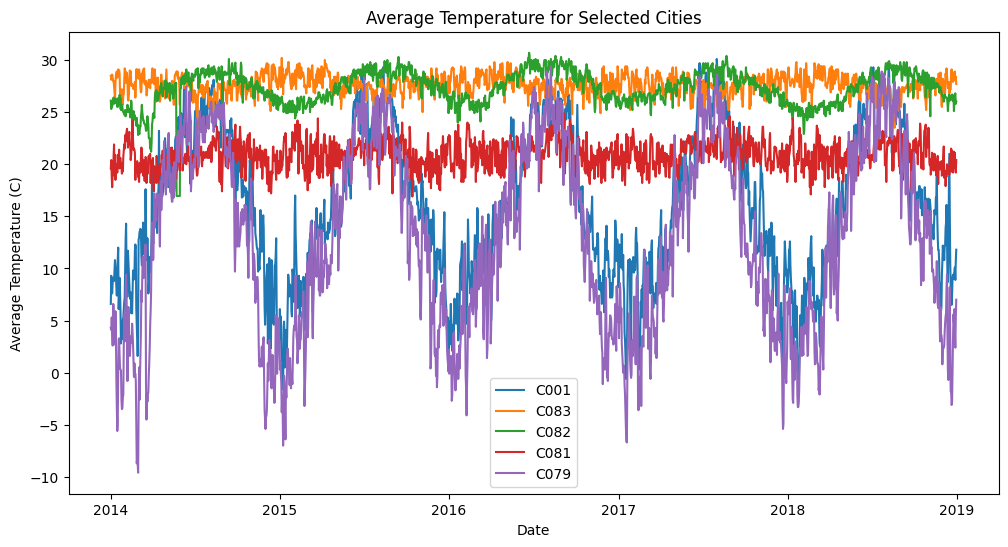

In [13]:
data = pd.read_csv('Data/historical_weather.csv', parse_dates=['date'])
data['city_id'] = data['city_id'].astype('category')
data.set_index('date', inplace=True)

def calc_mean(row):
    if pd.isna(row["avg_temp_c"]):
        if pd.isna(row["min_temp_c"]) and pd.isna(row["max_temp_c"]):
            return np.nan
        elif pd.isna(row["min_temp_c"]):
            return row["max_temp_c"]
        elif pd.isna(row["max_temp_c"]):
            return row["min_temp_c"]
        else:
            return (row["min_temp_c"] + row["max_temp_c"]) / 2
    return row["avg_temp_c"]


data['avg_temp_c'] = data.apply(lambda row: calc_mean(row), axis=1)

data['avg_temp_c'].fillna(method='ffill', inplace=True)
data.sort_index(inplace=True)
cities = data['city_id'].unique()[:5]  # Select first 5 cities for visualization
plt.figure(figsize=(12, 6))
for city in cities:
    city_data = data[data['city_id'] == city]
    plt.plot(city_data.index, city_data['avg_temp_c'], label=city)
plt.title('Average Temperature for Selected Cities')
plt.xlabel('Date')
plt.ylabel('Average Temperature (C)')
plt.legend()
plt.show()

# Function to perform SARIMA forecasting
def sarima_forecast(train, order, seasonal_order, steps):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=steps)
    return forecast



In [16]:
submission_key = pd.read_csv('Data/submission_key.csv', parse_dates=['date'])

# Function to perform SARIMA forecasting
def sarima_forecast(train, order, seasonal_order, steps):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=steps)
    return forecast

# Set parameters for SARIMA
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Initialize a list to hold the forecasts
forecasts = []

# Forecast horizon
forecast_horizon = submission_key['date'].nunique()
rmse_score = 0

# Iterate over each unique city in the submission key
for city in submission_key['city_id'].unique():
    # Get the training data for the city
    city_data = data[data['city_id'] == city]['avg_temp_c']
    train = city_data['2014-01-01':'2017-12-31']
    validation = city_data['2018-01-01':'2018-12-31']
    
    # Forecast using SARIMA
    forecast_validation = sarima_forecast(train, order, seasonal_order, steps=len(validation))
    
    # Evaluate the model on the 2018 validation data
    mse = mean_squared_error(validation, forecast_validation)
    rmse = np.sqrt(mse)
    print(f'Validation RMSE for city {city}: {rmse:.2f}')
    rmse_score += rmse
    
    # Forecast for 2019
    extended_train = city_data['2014-01-01':'2018-12-31']
    forecast_mean = sarima_forecast(extended_train, order, seasonal_order, steps=forecast_horizon)
    
    # Extract the forecast dates
    forecast_dates = pd.date_range(start='2019-01-01', periods=forecast_horizon, freq='D')
    
    # Create a DataFrame with forecasted values and dates
    forecast_df = pd.DataFrame({'date': forecast_dates, 'avg_temp_c': forecast_mean})
    
    # Merge forecast_df with submission_key to get the forecasts for required dates
    city_forecasts = submission_key[submission_key['city_id'] == city].merge(forecast_df, on='date', how='left')
    
    # Append the city forecasts to the forecasts list
    forecasts.append(city_forecasts)

# Concatenate all the forecasts
submission_df = pd.concat(forecasts)
submission_df.sort_values('submission_ID', inplace=True)
submission = submission_df[['submission_ID', 'avg_temp_c']]
submission.to_csv('submission.csv', index=False)

print("total RMSE Score: ", rmse_score)
print("Submission Data:")
print(submission.head())

Validation RMSE for city C001: 14.17
Validation RMSE for city C002: 6.77
Validation RMSE for city C003: 2.23
Validation RMSE for city C004: 12.02
Validation RMSE for city C005: 11.45
Validation RMSE for city C007: 7.33
Validation RMSE for city C008: 10.24
Validation RMSE for city C009: 10.63
Validation RMSE for city C010: 8.24
Validation RMSE for city C011: 17.52
Validation RMSE for city C012: 6.44
Validation RMSE for city C013: 11.94
Validation RMSE for city C014: 9.70
Validation RMSE for city C015: 4.36
Validation RMSE for city C016: 1.42
Validation RMSE for city C017: 1.83
Validation RMSE for city C018: 15.48
Validation RMSE for city C020: 2.33
Validation RMSE for city C022: 19.87
Validation RMSE for city C023: 2.59
Validation RMSE for city C024: 14.12
Validation RMSE for city C025: 7.88
Validation RMSE for city C027: 28.27
Validation RMSE for city C028: 1.48
Validation RMSE for city C029: 1.35
Validation RMSE for city C030: 1.32
Validation RMSE for city C031: 14.70
Validation RMSE 